# Lab 6: Variable Selection and Regularization
## Baseball Players

In [2]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

import warnings
from sklearn.exceptions import ConvergenceWarning

In [3]:
#Import dataset
hitters = pd.read_csv("C:/Users/ryanc/Desktop/GSB_544/Week7/hitters.csv")
hitters = hitters.dropna()

## Part 1: Different Model Specs

### A. Regression w/o regularization



In [4]:
X = hitters.drop("Salary", axis = 1)
y = hitters["Salary"]

lr = LinearRegression()

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression


2. Fit this pipeline to the full dataset, and interpret a few of the most important coefficients


3. Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [5]:
#1A-1

ct = ColumnTransformer(
    [
        ('dummify', OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
         make_column_selector(dtype_include=object)),
        ('standardize', StandardScaler(), make_column_selector(dtype_include=np.number))
        
    ],
    remainder = "passthrough"
).set_output(transform = "pandas")


# Linear Regression Pipeline

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

lr_pipeline_1

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F608FFEF10>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F608E83710>)])),
                ('linear_regression', LinearRegression())])

In [6]:
#1A-2

lr_pipeline_fitted1 = lr_pipeline_1.fit(X, y)
coef1 = lr_pipeline_fitted1.named_steps['linear_regression'].coef_

In [11]:
X_1 = ct.fit_transform(X)
X_1

X_1_df = pd.DataFrame(X_1, columns = ct.get_feature_names_out())

coef_df = pd.DataFrame([coef1], columns = X_1_df.columns)

coef_df_rounded = coef_df.round(3)

coef_df_transposed = coef_df_rounded.T

coef_df_transposed.reset_index(inplace = True)
coef_df_transposed.columns = ['Variable', 'Coefficient']
coef_df_sorted = coef_df_transposed.sort_values(by = 'Coefficient', ascending=False)


print(coef_df_sorted)

                Variable  Coefficient
16    standardize__CRuns      480.747
7      standardize__Hits      337.830
17     standardize__CRBI      260.690
11    standardize__Walks      135.074
14    standardize__CHits       86.688
19  standardize__PutOuts       78.761
2    dummify__Division_E       58.425
20  standardize__Assists       53.732
8     standardize__HmRun       37.854
1      dummify__League_N       31.300
4   dummify__NewLeague_A       12.381
5   dummify__NewLeague_N      -12.381
15   standardize__CHmRun      -14.182
12    standardize__Years      -16.693
21   standardize__Errors      -22.161
10      standardize__RBI      -26.995
0      dummify__League_A      -31.300
3    dummify__Division_W      -58.425
9      standardize__Runs      -60.572
18   standardize__CWalks     -213.892
6     standardize__AtBat     -291.095
13   standardize__CAtBat     -391.039


### **LR Model 1 Analysis**

#### Coefficients
- The largest coefficient was CRuns, which is the number of career runs the player had, at 480.747. It seems that career runs have a very strong impact on overall salary, as those with more runs earn much higher salaries. With the current model, a player's salary is expected to increase by roughly $480,750 dollars for every additional standard deviation increase in career runs. This seem to make sense, since scoring more runs is an extremely desirable trait in a player for MLB teams.
- The most negatively impactful coefficient is CAtBat, at -391.039. The more at bats that a player has seems to be associated with a drop in expected salary. This may seem counterintuitive, but it is possible that more career at bats is associated with a player getting older, thus less valuable. Younger players with more potential have less at bats, and it may smaller negative impact on their salary. 

In [12]:
#1A-3

scores1 = cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = 'neg_mean_squared_error')
mse_pred1 = -scores1
mse_pred1.mean()

121136.31031816883

**MSE expected when predicting 1989 salaries**

MSE = 121,136 thousand dollars

### B. Ridge regression
1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression


2. Use cross-validation to tune the hyperparameter.


3. Fit the pipeline with your chosen to the full dataset, and interpret a few of the most important coefficients.


4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [13]:
#1B-1

ridge_pipeline = Pipeline(
    [('preprocessing', ct),
     ('ridge_regression', Ridge(alpha = 1)) #Set this to 1 after tuning
        
    ]
)

ridge_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F608FFEF10>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F608E83710>)])),
                ('ridge_regression', Ridge(alpha=1))])

In [14]:
#1-B2: Tuning

results = [.001,.01,.1,1,10,100, 1000]
lambdas = {'ridge_regression__alpha': results}

gscv = GridSearchCV(ridge_pipeline, lambdas, cv = 5, scoring='neg_mean_squared_error')
gscv.fit(X, y)

pd.DataFrame(data = {"lambdas": results, "scores": gscv.cv_results_['mean_test_score']})

,lambdas,scores
0,0.001,-121124.458592
1,0.010,-121022.903286
2,0.100,-120343.621067
3,1.000,-119144.432677
4,10.000,-119348.984776
5,100.000,-120716.435589
6,1000.000,-134876.333803


In [15]:
results_df = pd.DataFrame(data={"lambdas": results, "scores": gscv.cv_results_['mean_test_score']})

# Find the row with the maximum score
best_row = results_df.loc[results_df['scores'].idxmax()]


best_lambda = best_row['lambdas']
best_score = best_row['scores']

print("Best Lambda:", best_lambda)
print("Best Score:", best_score)

Best Lambda: 1.0
Best Score: -119144.43267691578


In [16]:
#1B-3
ridge_pipeline_fitted = ridge_pipeline.fit(X, y)
coefR = ridge_pipeline_fitted.named_steps['ridge_regression'].coef_


coef_df = pd.DataFrame([coefR], columns = X_1_df.columns)

coef_df_rounded = coef_df.round(3)

coef_df_transposed = coef_df_rounded.T

coef_df_transposed.reset_index(inplace = True)
coef_df_transposed.columns = ['Variable', 'Coefficient']
coef_df_sorted = coef_df_transposed.sort_values(by = 'Coefficient', ascending=False)


print(coef_df_sorted)

                Variable  Coefficient
16    standardize__CRuns      320.412
7      standardize__Hits      296.645
17     standardize__CRBI      160.387
14    standardize__CHits      126.660
11    standardize__Walks      124.407
19  standardize__PutOuts       78.624
2    dummify__Division_E       60.016
20  standardize__Assists       47.463
15   standardize__CHmRun       39.071
1      dummify__League_N       30.439
8     standardize__HmRun       18.101
4   dummify__NewLeague_A       13.111
10      standardize__RBI       -9.113
5   dummify__NewLeague_N      -13.111
21   standardize__Errors      -23.724
9      standardize__Runs      -29.339
0      dummify__League_A      -30.439
12    standardize__Years      -38.668
3    dummify__Division_W      -60.016
18   standardize__CWalks     -184.424
13   standardize__CAtBat     -225.407
6     standardize__AtBat     -270.686


### Analyzing coefficients of ridge regression

- The highest coefficient, CRuns, seems to remain the same for this model. However, it has dropped down to 320.4. This means that for every standard deviation increase in career runs, we expect a player's salary to increase by roughly $320 thousand 
- While in the previous model, the lowest coefficient was CAtBat, it is now AtBat, which is the number of at bats for this specific season. So, for every standard deviation increase in at bats a player has had in 1986, we expect their salary to drop by \$270 thousand.

In [17]:
#1B-4: MSE for new model

scores2 = cross_val_score(ridge_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error')
mse_predRidge = -scores2
mse_predRidge.mean()

119144.43267691578

**MSE expected when predicting 1989 salaries with ridge regression**

MSE = 119,144 thousand dollars

### C. LASSO Regression

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. Use cross-validation to tune the Lambda hyperparameter.

3. Fit the pipeline with your chosen Lambda to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [18]:
#1C-1

lasso_pipeline = Pipeline(
    [('preprocessing', ct),
     ('lasso_regression', Lasso(alpha = 1)) #Alpha set after tuning
        
    ]
)

In [20]:
# 1.C.2

results2 = [.001,.01,.1,1,10,100, 1000]
lambdas2 = {'lasso_regression__alpha': results}

gscv_lasso = GridSearchCV(lasso_pipeline, lambdas2, cv = 5, scoring='neg_mean_squared_error')
gscv_lasso_fitted = gscv_lasso.fit(X, y)


pd.DataFrame(data = {"lambdas": results2, "scores": gscv_lasso_fitted.cv_results_['mean_test_score']})


warnings.simplefilter('ignore', ConvergenceWarning)

In [21]:
lasso_results_df = pd.DataFrame(data={"lambdas": results, "scores": gscv_lasso.cv_results_['mean_test_score']})

# Find the row with the maximum score
best_row = lasso_results_df.loc[lasso_results_df['scores'].idxmax()]


best_lambda = best_row['lambdas']
best_score = best_row['scores']

print("Best Lambda:", best_lambda)
print("Best Score:", best_score)

Best Lambda: 1.0
Best Score: -119761.58740741297


In [22]:
# 1.C.3

lasso_pipeline_fitted = lasso_pipeline.fit(X, y)
coef3 = lasso_pipeline_fitted.named_steps['lasso_regression'].coef_

coef_df = pd.DataFrame([coef3], columns = X_1_df.columns)

coef_df_rounded = coef_df.round(3)

coef_df_transposed = coef_df_rounded.T

coef_df_transposed.reset_index(inplace = True)
coef_df_transposed.columns = ['Variable', 'Coefficient']
coef_df_sorted = coef_df_transposed.sort_values(by = 'Coefficient', ascending=False)


print(coef_df_sorted)

                Variable  Coefficient
16    standardize__CRuns      375.566
7      standardize__Hits      304.360
17     standardize__CRBI      192.611
11    standardize__Walks      120.695
2    dummify__Division_E      114.413
19  standardize__PutOuts       78.760
20  standardize__Assists       41.997
15   standardize__CHmRun       14.226
8     standardize__HmRun       11.127
3    dummify__Division_W       -0.000
4   dummify__NewLeague_A        0.000
5   dummify__NewLeague_N       -0.000
10      standardize__RBI       -0.000
1      dummify__League_N        0.000
14    standardize__CHits        0.000
21   standardize__Errors      -18.479
9      standardize__Runs      -24.967
12    standardize__Years      -34.948
0      dummify__League_A      -35.826
13   standardize__CAtBat     -162.640
18   standardize__CWalks     -189.645
6     standardize__AtBat     -282.371


### Analyzing coefficients of LASSO regression

- The highest coefficient, CRuns, yet again remains the same for this model. However, it is back up to 375.566. This means that for every standard deviation increase in career runs, we expect a player's salary to increase by roughly \$376 thousand 
- Our LASSO model has the same lowest coefficient as the Ridge model, AtBat, which is the number of at bats for this specific season. So, for every standard deviation increase in at bats a player has had in 1986, we expect their salary to drop by \$282 thousand. This is an even more negative effect than with ridge, which was only 270 thousand.

In [23]:
#1C-4

warnings.simplefilter('ignore', ConvergenceWarning)

scores3 = cross_val_score(lasso_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error')
mse_predlasso = -scores3
mse_predlasso.mean()

119761.58740741297

**MSE expected when predicting 1989 salaries with Lasso regression**

MSE = 119,761 thousand dollars

### D. Elastic Net

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. Use cross-validation to tune the Lambda and alpha hyperparameters.

3. Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [24]:
#1D-1

elastic_pipeline = Pipeline(
    [('preprocessing', ct),
    ('elasticnet', ElasticNet(alpha=0.1, l1_ratio=0.8))#Set after tuning
    ]
)

In [25]:
#1D-2

warnings.simplefilter('ignore', ConvergenceWarning)

param_grid_elastic = {
    'elasticnet__alpha': [0.01, 0.1, 1, 10, 100],
    'elasticnet__l1_ratio': [0.2, 0.4, 0.6, 0.8]
}


gscv_elastic = GridSearchCV(elastic_pipeline, param_grid_elastic, cv=5, scoring='neg_mean_squared_error')
gscv_elastic_fitted = gscv_elastic.fit(X, y)


best_params = gscv_elastic_fitted.best_params_
best_score_elastic = -(gscv_elastic_fitted.best_score_)

print("Best Parameters:", best_params)
print("Best Score:", best_score_elastic)

Best Parameters: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.8}
Best Score: 118994.42787368372


In [26]:
# 1.D.3

elastic_pipeline_fitted = elastic_pipeline.fit(X, y)
coef4 = elastic_pipeline_fitted.named_steps['elasticnet'].coef_

coef_df = pd.DataFrame([coef4], columns = X_1_df.columns)

coef_df_rounded = coef_df.round(3)

coef_df_transposed = coef_df_rounded.T

coef_df_transposed.reset_index(inplace = True)
coef_df_transposed.columns = ['Variable', 'Coefficient']
coef_df_sorted = coef_df_transposed.sort_values(by = 'Coefficient', ascending=False)


print(coef_df_sorted)


                Variable  Coefficient
7      standardize__Hits      200.550
16    standardize__CRuns      163.216
14    standardize__CHits      110.759
17     standardize__CRBI      104.765
11    standardize__Walks       97.556
19  standardize__PutOuts       76.813
2    dummify__Division_E       60.749
15   standardize__CHmRun       59.261
20  standardize__Assists       34.983
1      dummify__League_N       26.238
4   dummify__NewLeague_A        9.679
10      standardize__RBI        9.379
9      standardize__Runs        9.359
8     standardize__HmRun       -3.277
5   dummify__NewLeague_N       -9.681
21   standardize__Errors      -24.952
0      dummify__League_A      -26.237
12    standardize__Years      -52.181
13   standardize__CAtBat      -56.854
3    dummify__Division_W      -60.750
18   standardize__CWalks     -125.754
6     standardize__AtBat     -184.996


### Analyzing coefficients of Elastic Net Model

- The highest coefficient has changed for the first time, and is now Hits in the 1986 season. This implies that players with more hits are expected to earn higher salaries than those with less hits. In relation to the model, we expect a player's salary to increase by around 200 thousand dollars for every st dev increase in the number of hits they have in 1986.
- Our Elastic model has the same lowest coefficient as the Ridge model and lasso model, AtBat, which is the number of at bats for this specific season. So, for every standard deviation increase in at bats a player has had in 1986, we expect their salary to drop by \$184 thousand. This is less of a negative impact than it was with the previous two models.

In [27]:
#1D-4

scores4 = cross_val_score(elastic_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error')
mse_predElastic = -scores4
mse_predElastic.mean()

118994.42787368372

**MSE expected when predicting 1989 salaries with Elastic net model**

MSE = 118,994 thousand dollars

# Part 2: Variable Selection

Based on the above results, decide on:

- Which numeric variable is most important.

- Which five numeric variables are most important

- Which categorical variable is most important

For each of the four model specifications, compare the following possible feature sets:

- Using only the one best numeric variable.

- Using only the five best variables.

- Using the five best numeric variables and their interactions with the one best categorical variable.

Report which combination of features and model performed best, based on the validation metric of MSE.

(Note: Lambda and Alpha must be re-tuned for each feature set.)

In [39]:
X = hitters[['Hits','CRBI','CRuns','AtBat','Walks','Division']]

y = hitters["Salary"]

### Linear Models

In [40]:
#LR Only Hits
ct = ColumnTransformer(
    transformers=[
        ('Standardize', StandardScaler(), ['Hits']),
    ], remainder = "drop"
).set_output(transform = "pandas")

lr_pipelineHits = Pipeline([
    ('preprocessing', ct),
    ('linear_regression', LinearRegression())
])

lr_pipelineHits.fit(X, y)

scores = cross_val_score(lr_pipelineHits, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"LR Hits Mean Squared Error: {mean_mse}")

LR Hits Mean Squared Error: 173088.9728644403


In [30]:
#LR Top 5
# Column transformer that standardizes and dummies
ct = ColumnTransformer(
    transformers=[
        ('Standardize', StandardScaler(), ['Hits','CRBI','CRuns','AtBat','Walks']),
    ], remainder = "drop"
).set_output(transform = "pandas")

# pipeline
lr_pipelineTop5 = Pipeline([
    ('preprocessing', ct),
    ('linear_regression', LinearRegression())
])

# Fit pipline
lr_pipelineTop5.fit(X, y)


scores = cross_val_score(lr_pipelineTop5, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"LR Top 5 Mean Squared Error: {mean_mse}")

LR Top 5 Mean Squared Error: 119906.79075868055


In [32]:
# LR Top 5 + Interaction. Standardizing and dummifying.
ct = ColumnTransformer(
    transformers=[
        ("dummify", OneHotEncoder(sparse_output = False), ["Division"]),
        ('Standardize', StandardScaler(), ['Hits','CRBI','CRuns','AtBat','Walks']),
    ], remainder = "passthrough"
).set_output(transform = "pandas")

ct_inter = ColumnTransformer(
  [
    ("interaction1", PolynomialFeatures(interaction_only = True), ["Standardize__Hits", "dummify__Division_E"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["Standardize__CRBI", "dummify__Division_E"]),
    ("interaction3", PolynomialFeatures(interaction_only = True), ["Standardize__CRuns", "dummify__Division_E"]),
    ("interaction4", PolynomialFeatures(interaction_only = True), ["Standardize__AtBat", "dummify__Division_E"]),
    ("interaction5", PolynomialFeatures(interaction_only = True), ["Standardize__Walks", "dummify__Division_E"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")

# pipeline
lr_pipelineTop5int = Pipeline([
    ('preprocessing', ct),
   ("interaction", ct_inter),
    ('linear_regression', LinearRegression())
])

# Fit pipline
lr_pipelineTop5int.fit(X, y)


scores = cross_val_score(lr_pipelineTop5int, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"LR Top 5 + Interact Mean Squared Error: {mean_mse}")

LR Top 5 + Interact Mean Squared Error: 122782.08848146773


Of the 3 linear models, the one with the top 5 variables and no interactions performed the best.

### Ridge

In [33]:
# Ridge Only Hits w/ Tuning

ct = ColumnTransformer(
    transformers=[
        ('Standardize', StandardScaler(), ['Hits']),
    ], remainder = "drop"
).set_output(transform = "pandas")


ridge_pipelineHits = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge())]
)

results = [1,10,100]

lambdas = {'ridge_regression__alpha': results}

gscv = GridSearchCV(ridge_pipelineHits, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)
mse_scores = -gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data={"lambdas": results, "MSE scores": mse_scores})

,lambdas,MSE scores
0,1,173046.230311
1,10,172755.975523
2,100,174448.308656


In [34]:
# Ridge Only Hits w/ best lambda
ridge_pipelineHits = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=10))]
)

ridge_pipelineHits.fit(X,y)

scores = cross_val_score(ridge_pipelineHits, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Ridge Reg Hits Mean Squared Error: {mean_mse}")

Ridge Reg Hits Mean Squared Error: 172755.97552343184


In [35]:
#Ridge Top 5 w/ Tuning

ct = ColumnTransformer(
    transformers=[
        ('Standardize', StandardScaler(), ['Hits','CRBI','CRuns','AtBat','Walks']),
    ], remainder = "drop"
).set_output(transform = "pandas")


ridge_pipelineTop5 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge())]
)

results = [0.1,1,10,100]

lambdas = {'ridge_regression__alpha': results}

gscv = GridSearchCV(ridge_pipelineTop5, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)
mse_scores = -gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data={"lambdas": results, "MSE scores": mse_scores})

,lambdas,MSE scores
0,0.1,119832.764215
1,1.0,119386.669648
2,10.0,119946.973728
3,100.0,123578.477116


In [36]:
#Ridge Top 5 w/ best lambda

ridge_pipelineTop5 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=1))]
)

ridge_pipelineTop5.fit(X,y)

scores = cross_val_score(ridge_pipelineTop5, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Ridge Reg Top5 Mean Squared Error: {mean_mse}")

Ridge Reg Top5 Mean Squared Error: 119386.66964827264


In [39]:
#Ridge Top 5 + Interaction. With tuning.

ct = ColumnTransformer(
    transformers=[
        ("dummify", OneHotEncoder(sparse_output = False), ["Division"]),
        ('Standardize', StandardScaler(), ['Hits','CRBI','CRuns','AtBat','Walks']),
    ], remainder = "passthrough"
).set_output(transform = "pandas")

ct_inter = ColumnTransformer(
  [
    ("interaction1", PolynomialFeatures(interaction_only = True), ["Standardize__Hits", "dummify__Division_E"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["Standardize__CRBI", "dummify__Division_E"]),
    ("interaction3", PolynomialFeatures(interaction_only = True), ["Standardize__CRuns", "dummify__Division_E"]),
    ("interaction4", PolynomialFeatures(interaction_only = True), ["Standardize__AtBat", "dummify__Division_E"]),
    ("interaction5", PolynomialFeatures(interaction_only = True), ["Standardize__Walks", "dummify__Division_E"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")

# Creates pipeline
ridge_pipelineTop5int = Pipeline([
    ('preprocessing', ct),
   ("interaction", ct_inter),
    ('ridge_regression', Ridge())
])

results = [1,10,100,1000]

lambdas = {'ridge_regression__alpha': results}

gscv = GridSearchCV(ridge_pipelineTop5int, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)
mse_scores = -gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data={"lambdas": results, "MSE scores": mse_scores})

,lambdas,MSE scores
0,1,119202.542721
1,10,116985.613336
2,100,117413.597417
3,1000,144253.919247


In [40]:
#Ridge Top 5 + Interaction


ridge_pipelineTop5int = Pipeline([
    ('preprocessing', ct),
   ("interaction", ct_inter),
    ('ridge_regression', Ridge(alpha=10))
])

ridge_pipelineTop5int.fit(X,y)

scores = cross_val_score(ridge_pipelineTop5int, X, y, cv=5, scoring='neg_mean_squared_error')
mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Ridge Reg Top5 + Int Mean Squared Error: {mean_mse}")

Ridge Reg Top5 + Int Mean Squared Error: 116985.61333614467


### LASSO

In [41]:
# Lasso Only Hits Tuning

ct = ColumnTransformer(
    transformers=[
        ('Standardize', StandardScaler(), ['Hits']),
    ], remainder = "drop"
).set_output(transform = "pandas")


lasso_pipelineHits = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso())]
)

results = [1,10,100]

lambdas = {'lasso_regression__alpha': results}

gscv = GridSearchCV(lasso_pipelineHits, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)
mse_scores = -gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data={"lambdas": results, "MSE scores": mse_scores})

,lambdas,MSE scores
0,1,173076.934306
1,10,173061.634500
2,100,182120.311402


In [42]:
# Lasso Only Hits w/ best lamda
lasso_pipelineHits = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso(alpha=10))]
)

lasso_pipelineHits.fit(X,y)

scores = cross_val_score(lasso_pipelineHits, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Lasso Reg Hits Mean Squared Error: {mean_mse}")

Lasso Reg Hits Mean Squared Error: 173061.63450002926


In [45]:
#Lasso Top 5 w/ Tuning

ct = ColumnTransformer(
    transformers=[
        ('Standardize', StandardScaler(), ['Hits','CRBI','CRuns','AtBat','Walks']),
    ], remainder = "drop"
).set_output(transform = "pandas")


lasso_pipelineTop5 = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso())]
)

results = [.0000001,.000001,.00001,.0001, .001, .01, 1.0, 10, 100]

lambdas = {'lasso_regression__alpha': results}

gscv = GridSearchCV(lasso_pipelineTop5, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)
mse_scores = -gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data={"lambdas": results, "MSE scores": mse_scores})

,lambdas,MSE scores
0,1.000000e-07,119906.790707
1,1.000000e-06,119906.790244
2,1.000000e-05,119906.785614
3,1.000000e-04,119906.739296
4,1.000000e-03,119906.276423
5,1.000000e-02,119901.656157
6,1.000000e+00,119509.429219
7,1.000000e+01,124278.714238
8,1.000000e+02,142515.321400


In [46]:
#Lasso Top 5


# optimal lambda
lasso_pipelineTop5 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Lasso(alpha=1))]
)

lasso_pipelineTop5.fit(X,y)

scores = cross_val_score(lasso_pipelineTop5, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Lasso Reg Top5 Mean Squared Error: {mean_mse}")

Lasso Reg Top5 Mean Squared Error: 119509.429219181


In [50]:
#Lasso Top 5 + Interaction w/ Tuning

ct = ColumnTransformer(
    transformers=[
        ("dummify", OneHotEncoder(sparse_output = False), ["Division"]),
        ('Standardize', StandardScaler(), ['Hits','CRBI','CRuns','AtBat','Walks']),
    ], remainder = "passthrough"
).set_output(transform = "pandas")

ct_inter = ColumnTransformer(
  [
    ("interaction1", PolynomialFeatures(interaction_only = True), ["Standardize__Hits", "dummify__Division_E"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["Standardize__CRBI", "dummify__Division_E"]),
    ("interaction3", PolynomialFeatures(interaction_only = True), ["Standardize__CRuns", "dummify__Division_E"]),
    ("interaction4", PolynomialFeatures(interaction_only = True), ["Standardize__AtBat", "dummify__Division_E"]),
    ("interaction5", PolynomialFeatures(interaction_only = True), ["Standardize__Walks", "dummify__Division_E"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")


lasso_pipelineTop5int = Pipeline([
    ('preprocessing', ct),
   ("interaction", ct_inter),
    ('lasso_regression', Ridge())
])

results = [1,10,100,1000]

lambdas = {'lasso_regression__alpha': results}

gscv = GridSearchCV(lasso_pipelineTop5int, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)
mse_scores = -gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data={"lambdas": results, "MSE scores": mse_scores})

,lambdas,MSE scores
0,1,119202.542721
1,10,116985.613336
2,100,117413.597417
3,1000,144253.919247


In [49]:
#Lasso Top 5 w/ Interactions and best lambda

lasso_pipelineTop5int = Pipeline([
    ('preprocessing', ct),
   ("interaction", ct_inter),
    ('ridge_regression', Ridge(alpha=10))
])

lasso_pipelineTop5int.fit(X,y)

scores = cross_val_score(lasso_pipelineTop5int, X, y, cv=5, scoring='neg_mean_squared_error')
mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Lasso Reg Top5 + Int Mean Squared Error: {mean_mse}")

Lasso Reg Top5 + Int Mean Squared Error: 116985.61333614467


### Elastic net

In [58]:
# Elastic Net Only Hits and tuning

ct = ColumnTransformer(
    transformers=[
        ('Standardize', StandardScaler(), ['Hits']),
    ], remainder = "drop"
).set_output(transform = "pandas")


# Creating pipeline
enet_pipelineHits = Pipeline(
  [("preprocessing", ct),
   ("enet_regression", ElasticNet(max_iter=100000, tol=0.1))]
)


lambdas = {
    'enet_regression__alpha': np.linspace(0.01, 1, 10),
    'enet_regression__l1_ratio': np.linspace(0.01, 1, 10)
}

# GridSearchCV
gscv = GridSearchCV(enet_pipelineHits, lambdas, cv=5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X,y)


results = gscv.cv_results_


df = pd.DataFrame({
    'alpha': results['param_enet_regression__alpha'],
    'l1_ratio': results['param_enet_regression__l1_ratio'],
    'mean_squared_error': -results['mean_test_score']  # Negating because scores are negative MSE
})

results_df = df.sort_values(by='mean_squared_error')
results_df.head(5)

,alpha,l1_ratio,mean_squared_error
10,0.12,0.01,172569.569811
24,0.23,0.45,172571.467365
36,0.34,0.67,172578.968935
11,0.12,0.12,172579.376881
57,0.56,0.78,172581.201475


In [60]:
# Elastic Net Only Hits


enet_pipelineHits = Pipeline(
  [("preprocessing", ct),
   ("enet_regression", ElasticNet(alpha=0.12, l1_ratio=0.01, max_iter=100000, tol=0.1))]
)

enet_pipelineHits.fit(X,y)

scores = cross_val_score(lasso_pipelineHits, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Elastic Net Hits Mean Squared Error: {mean_mse}")



Elastic Net Hits Mean Squared Error: 173061.63450002926


In [61]:
#Elastic Net Top 5 with tuning

ct = ColumnTransformer(
    transformers=[
        ('Standardize', StandardScaler(), ['Hits','CRBI','CRuns','AtBat','Walks']),
    ], remainder = "drop"
).set_output(transform = "pandas")


enet_pipelineTop5 = Pipeline(
  [("preprocessing", ct),
   ("enet_regression", ElasticNet(max_iter=10000, tol=0.1))]
)


lambdas = {
    'enet_regression__alpha': np.linspace(0.1, 1, 10),
    'enet_regression__l1_ratio': np.linspace(0.1, 1, 10)
}

# GridSearchCV
gscv = GridSearchCV(enet_pipelineTop5, lambdas, cv=5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X,y)


results = gscv.cv_results_


df = pd.DataFrame({
    'alpha': results['param_enet_regression__alpha'],
    'l1_ratio': results['param_enet_regression__l1_ratio'],
    'mean_squared_error': -results['mean_test_score']  # Negating because scores are negative MSE
})

results_df = df.sort_values(by='mean_squared_error')
results_df.head(5)

,alpha,l1_ratio,mean_squared_error
8,0.1,0.9,119184.373130
7,0.1,0.8,119269.652955
18,0.2,0.9,119318.858784
99,1.0,1.0,119437.390250
89,0.9,1.0,119458.035010


In [62]:
#Elastic Net Top 5 

enet_pipelineTop5 = Pipeline(
  [("preprocessing", ct),
   ("enet_regression", ElasticNet(alpha=0.1, l1_ratio=0.9, max_iter=10000, tol=0.1))]
)

enet_pipelineTop5.fit(X,y)

scores = cross_val_score(enet_pipelineTop5, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Elastic Net Top 5 Mean Squared Error: {mean_mse}")

Elastic Net Top 5 Mean Squared Error: 119184.373130125


In [63]:
#Elastic Net Top 5 + Interaction Tuning

ct = ColumnTransformer(
    transformers=[
        ("dummify", OneHotEncoder(sparse_output = False), ["Division"]),
        ('Standardize', StandardScaler(), ['Hits','CRBI','CRuns','AtBat','Walks']),
    ], remainder = "passthrough"
).set_output(transform = "pandas")

ct_inter = ColumnTransformer(
  [
    ("interaction1", PolynomialFeatures(interaction_only = True), ["Standardize__Hits", "dummify__Division_E"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["Standardize__CRBI", "dummify__Division_E"]),
    ("interaction3", PolynomialFeatures(interaction_only = True), ["Standardize__CRuns", "dummify__Division_E"]),
    ("interaction4", PolynomialFeatures(interaction_only = True), ["Standardize__AtBat", "dummify__Division_E"]),
    ("interaction5", PolynomialFeatures(interaction_only = True), ["Standardize__Walks", "dummify__Division_E"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")


enet_pipelineTop5int = Pipeline([
    ('preprocessing', ct),
   ("interaction", ct_inter),
    ("enet_regression", ElasticNet(max_iter=10000, tol=0.1))
])

# parameter grid
lambdas = {
    'enet_regression__alpha': np.linspace(0.1, 1, 10),
    'enet_regression__l1_ratio': np.linspace(0.1, 1, 10)
}

# GridSearchCV
gscv = GridSearchCV(enet_pipelineTop5int, lambdas, cv=5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X,y)


results = gscv.cv_results_


df = pd.DataFrame({
    'alpha': results['param_enet_regression__alpha'],
    'l1_ratio': results['param_enet_regression__l1_ratio'],
    'mean_squared_error': -results['mean_test_score']  # Negating because scores are negative MSE
})

results_df = df.sort_values(by='mean_squared_error')
results_df.head(5)

,alpha,l1_ratio,mean_squared_error
68,0.7,0.9,116811.165058
58,0.6,0.9,116815.586233
88,0.9,0.9,116835.312344
78,0.8,0.9,116842.895264
48,0.5,0.9,116925.896813


In [64]:
#Elastic Net Top 5 + Interaction
# Creates pipeline
enet_pipelineTop5int = Pipeline([
    ('preprocessing', ct),
   ("interaction", ct_inter),
    ("enet_regression", ElasticNet(alpha=0.7,l1_ratio=0.9,max_iter=10000, tol=0.1))
])

enet_pipelineTop5int.fit(X,y)

scores = cross_val_score(enet_pipelineTop5int, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Elastic Net Top 5 + Int Mean Squared Error: {mean_mse}")

Elastic Net Top 5 + Int Mean Squared Error: 116811.16505782341


### Part 3: Discussion

In [66]:
# Comparing all Model MSEs

mse_data = {
    "Linear": [173088.9728644403, 119906.79075868055, 122782.08848146773],
    "Ridge": [172755.97552343184, 119386.66964827264, 116985.61333614467],
    "LASSO": [173061.63450002926, 119509.429219181, 116985.61333614467],
    "Elastic Net": [173061.63450002926, 119184.373130125, 116811.16505782341]
}

df = pd.DataFrame(mse_data, index=["Hits Only MSE", "Top 5 MSE", "Top 5 + Int 3 MSE"])

df = df.style.set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold')]},  # Bold headers
])

df

,Linear,Ridge,LASSO,Elastic Net
Hits Only MSE,173088.972864,172755.975523,173061.634500,173061.634500
Top 5 MSE,119906.790759,119386.669648,119509.429219,119184.373130
Top 5 + Int 3 MSE,122782.088481,116985.613336,116985.613336,116811.165058


#### A. Ridge

Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

*Ridge regression had better regression models for each of the three methods, and almsot always had smaller coefficients. Part of this is most likely due to the fact that Ridge regression makes an effort to keep coefficients low to prevent overfitting. Variables may also be related, and Ridge regression can balance their influence. For example, CRuns, Hits, and CRBIs are all related, but linear regression may give too much importance to these variables, resulting in a worse model.*

#### B. LASSO

Compare your LASSO model in I with your three LASSO models in II. Did you get the same results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

*The results changed for each of these models, which makes sense because we are using different predictors for each one. It also makes sense that the lambda would change based on these predictors. For example, the MSE was lowest with the Lasso model that included all top 5 coefficients along with interactions, at 116,985.*

#### C. Elastic Net

Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

*Because Elastic Net is a combination of the best features of ridge and lasso, it makes sense that the MSE would be the lowest for these. Its ability to balance the handling of related variables (Ridge) and the most influential variables (LASSO), makes it a good predictor.*

### Part 4: Final Model

In [67]:
X = hitters.drop(["Salary"],axis=1)
y = hitters["Salary"]

#Best Model
# pipeline
best_pipeline = Pipeline([
    ('preprocessing', ct),
   ("interaction", ct_inter),
    ("enet_regression", ElasticNet(alpha=0.7,l1_ratio=0.9,max_iter=10000, tol=0.1))
])

#Fit entire dataset
best_pipeline.fit(X,y)

scores = cross_val_score(best_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Best Model Mean Squared Error: {mean_mse}")

Best Model Mean Squared Error: 116811.16505782341


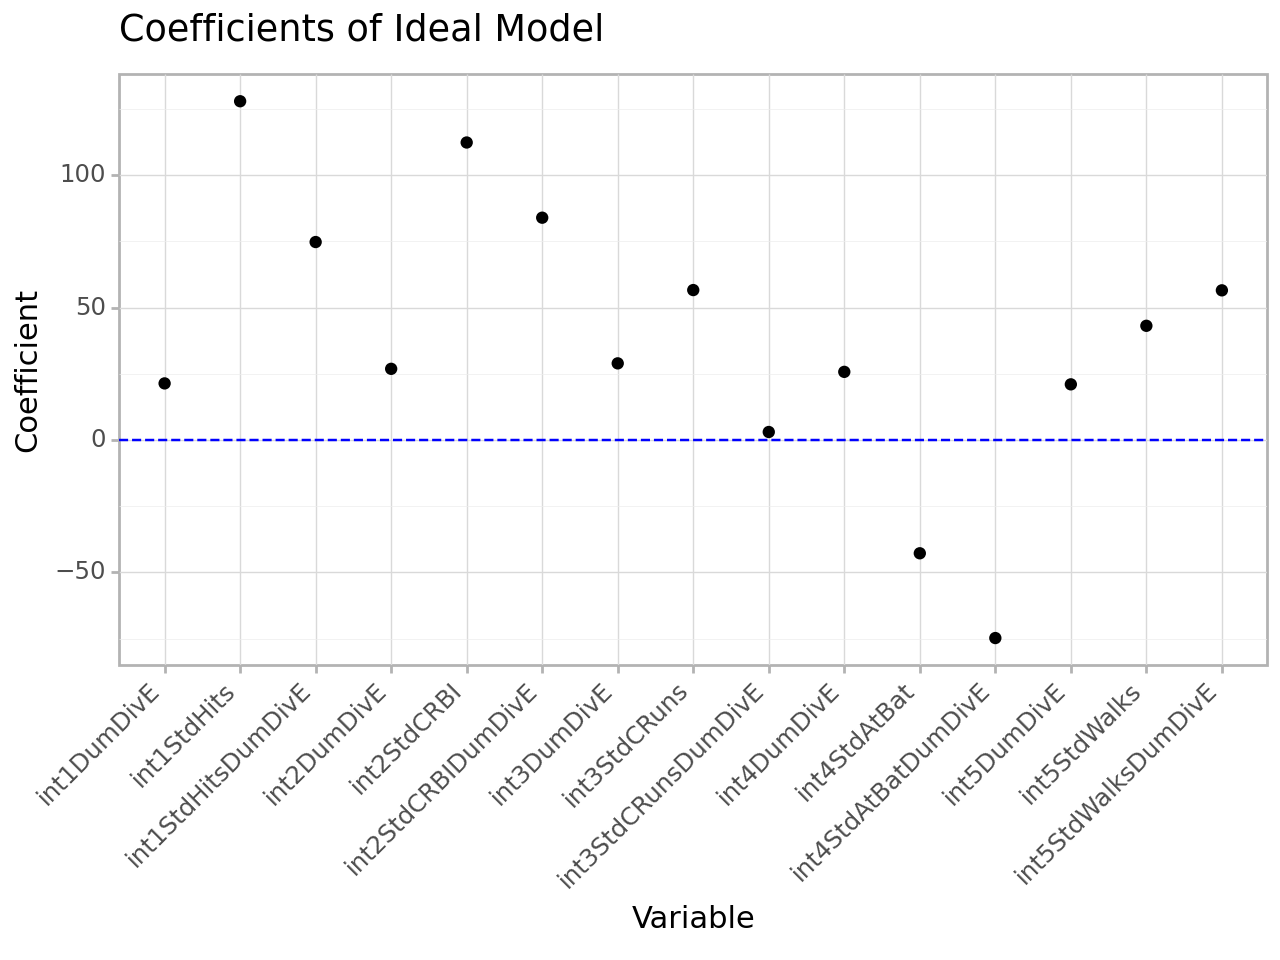

<Figure Size: (640 x 480)>

In [82]:
# Coefficients & var names
coefficients = best_pipeline.named_steps['enet_regression'].coef_

var_names = ct_inter.get_feature_names_out()

# DataFrame
coef_df = pd.DataFrame({
    'Variable': var_names,
    'Coefficient': coefficients
})

# Filter out zero coefficients
coef_df = coef_df[coef_df['Coefficient'] != 0]

import pandas as pd


# Replace 'interaction' with 'int', remove underscores and spaces
coef_df['Variable'] = coef_df['Variable'].str.replace('interaction', 'int', regex=False)
coef_df['Variable'] = coef_df['Variable'].str.replace('Standardize', 'Std', regex=False)
coef_df['Variable'] = coef_df['Variable'].str.replace('dummify', 'Dum', regex=False)
coef_df['Variable'] = coef_df['Variable'].str.replace('Division', 'Div', regex=False)
coef_df['Variable'] = coef_df['Variable'].str.replace('[ _]', '', regex=True)


(ggplot(coef_df, aes(x='Variable', y='Coefficient'))
 + geom_point()
 + theme_light()
 + geom_hline(yintercept=0, color="blue", linetype="dashed")
 + theme(axis_text_x=element_text(angle=45, hjust=1))
 + ggtitle('Coefficients of Ideal Model'))

It looks like the ideal model has mostly positive coefficients, but there are a couple that are negative. This may have been due to the way this model was set up, and how it removed some of the negative influences due to variables being related to one another. The most influential variables were things like Hits, CRBI's, CRuns, and AtBat, the last one having a negative impact. 

The most positively iunfluential variable was the standardized Hits, while the most negatively influential was the interaction between At Bats and Division E. It makes sense that hits is a big predictor of salary, but I still find it surprising that an increase in At Bats, and not Career at bats, can have a negative influence on salary. It might be that more at bats is not necessarily an indicator of how good a player is, rather how good their team might be. 